# Audio embeddings using deep LSTM autoencoder

Firstly, we import two mono audio samples, one for training and one for validation.

In [2]:
from helpers import wav_to_array_dialog
audio = wav_to_array_dialog()
val_audio = wav_to_array_dialog()

Then, we perform a gammatone spectral analysis on a part of the audio. Let's test it on a segment of audio with a spectral resolution of 200 frequency bins and a temporal resolution of 0.025 seconds. We plot it to demonstrate its properties.

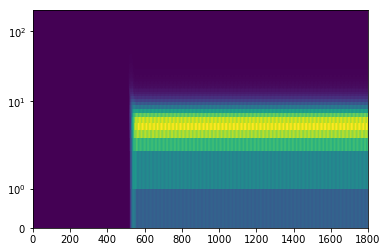

In [71]:
from data import perform_gammatone_spectrogram
val_gammatone = perform_gammatone_spectrogram(audio[500000:600000], 44100, 0.025, 0.00125, 200, 30)

import matplotlib.pyplot as plt
plt.pcolormesh(val_gammatone)
plt.yscale('symlog')
plt.show()

Let's organize the frequencies in dilated spectral frames. We will instantiate a GammatoneFilterbank and have it perform dilated spectral analysis on a segment of audio. We plot a single frame to demonstrate its properties.

- Sample rate: 44100 kHz
- Temporal resolution: 0.01 seconds per frame (441 samples per frame)
- Spectral resolution: 100 filters
- Num historic frames: 8 (translates to 2.56s of memory)
- Dilation factor: 2 (which translates to 2^n for historic frames)

In [72]:
# Set params
sample_rate = 44100
window_size_seconds = 0.01
num_filters = 100
cutoff_low_hz = 30
frames_in_memory = 8

# Prepare dilated gammatone processing
from gammatone_filterbank import GammatoneFilterbank
filterbank = GammatoneFilterbank(sample_rate, window_size_seconds, window_size_seconds / 2, num_filters, cutoff_low_hz)

# Make train and val sets
train = filterbank.make_dilated_spectral_frames(audio, frames_in_memory, 2)
val = filterbank.make_dilated_spectral_frames(val_audio, frames_in_memory, 2)

# Normalize values across spectrogram
train = train/train.max()
val = val/val.max()

Let's plot some examples from the training and validation data to vizualize the dilated spectral buffer. The horizontal axis represents frequency content and the vertical axis represents time.

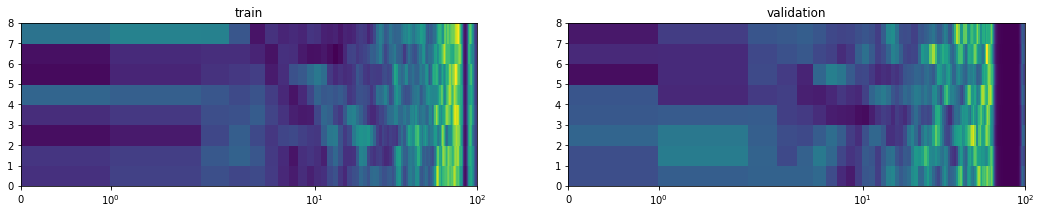

In [73]:
# Plot and print data
plt.figure(figsize=(18,3))
plt.subplot(1, 2, 1)
plt.xscale('symlog')
plt.title('train')
plt.pcolormesh(train[500])
plt.subplot(1, 2, 2)
plt.xscale('symlog')
plt.title('validation')
plt.pcolormesh(val[600])
plt.show()

We want to try and use these frames of dilated frequencies to create usable temporal audio embeddings which can be used in neural networks. Ideally, the temporal context of the frequencies at a current moment, should be compressed down into a smaller unidimensional space. We prepare an LSTM Autoencoder for this purpose. 

In [74]:
from model import prepare_autoencoder
autoencoder, encoder = prepare_autoencoder(frames_in_memory, num_filters, 300, "rmsprop", "mean_squared_error")

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 50)             30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               421200    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 300)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 50)             70200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 100)            60400     
Total params: 582,000
Trainable params: 582,000
Non-trainable params: 0
_________________________________________________________________
None

Now that the autoencoder model has been prepared, let's fit it and plot the results!

In [75]:
autoencoder.load_weights("C:/Users/Rothmann/Documents/PROJECTS/Development/Thesis/Keras/Models/LSTM_Autoencoder/LSTM1_weights.h5")
history = autoencoder.fit(train, train, epochs=10, batch_size=500, validation_data=(val, val))

Train on 76625 samples, validate on 76625 samples
Epoch 1/10
76625/76625 [==============================] - 67s - loss: 1.9552e-04 - acc: 0.4258 - val_loss: 2.4232e-04 - val_acc: 0.4759
Epoch 2/10
76625/76625 [==============================] - 65s - loss: 1.7566e-04 - acc: 0.4298 - val_loss: 2.2607e-04 - val_acc: 0.4675
Epoch 3/10
76625/76625 [==============================] - 66s - loss: 1.6524e-04 - acc: 0.4317 - val_loss: 2.2959e-04 - val_acc: 0.4797
Epoch 4/10
76625/76625 [==============================] - 65s - loss: 1.5722e-04 - acc: 0.4330 - val_loss: 2.3357e-04 - val_acc: 0.4637
Epoch 5/10
76625/76625 [==============================] - 66s - loss: 1.5055e-04 - acc: 0.4339 - val_loss: 2.2234e-04 - val_acc: 0.4698
Epoch 6/10
76625/76625 [==============================] - 67s - loss: 1.4489e-04 - acc: 0.4356 - val_loss: 2.2138e-04 - val_acc: 0.4790
Epoch 7/10
76625/76625 [==============================] - 65s - loss: 1.3961e-04 - acc: 0.4367 - val_loss: 2.1443e-04 - val_acc: 0.478

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


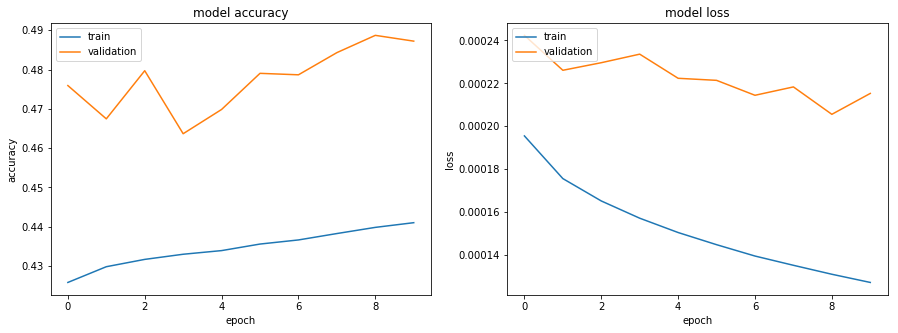

In [76]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Loss"
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

After the model has been fit, let's save its weights.

In [77]:
# save_path = get_save_path()
autoencoder.save_weights("C:/Users/Rothmann/Documents/PROJECTS/Development/Thesis/Keras/Models/LSTM_Autoencoder/autoencoder_weights.h5")

Let's predict some encodings to compare the encoded data with the original:

In [78]:
prediction = autoencoder.predict(x=val[:50000], batch_size=200, verbose=True)

50000/50000 [==============================] - 11s    


We'll plot a few of these encodings to get an idea of how well it worked. Looks like the temporal context is reconstructing quite well!

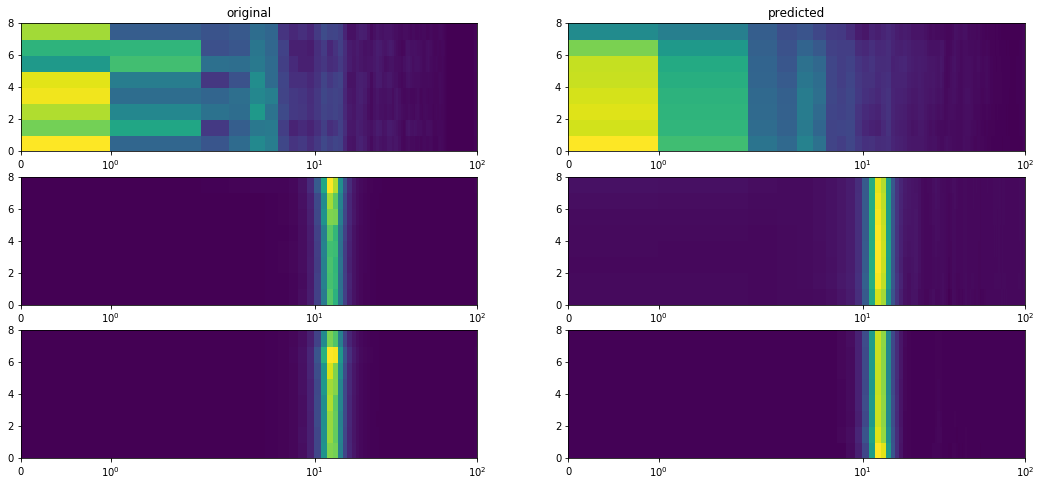

In [79]:
from random import *

plt.figure(figsize=(18,8))

for i in range(3):
    rand_example = randint(1, 50000)
    
    plt.subplot(3, 2, i * 2 + 1)
    plt.xscale('symlog')
    if i == 0:
        plt.title('original')
    plt.pcolormesh(val[rand_example])
    
    plt.subplot(3, 2,  i * 2 + 2)
    plt.xscale('symlog')
    if i == 0:
        plt.title('predicted')
    plt.pcolormesh(prediction[rand_example])
     
plt.show()

# The processing network

Now that the temporal spectral embeddings have been created, let's create a processing network that will receive them as input and produce audio.

In [80]:
encodings = encoder.predict(x=train, batch_size=500, verbose=True)

76500/76625 [============================>.] - ETA: 0s

We will break the y data (also used for validation in the autoencoder) into bits representing the number of samples to be predicted per gammatone window.

In [4]:
import numpy as np
train_y = np.array_split(val_audio, int(len(encodings)))
train_y = (np.vstack(train_y[500:]) + 1) * 2 # Scale audio samples for higher prediction fidelity
train_x = encodings[500:]
# train_y = np.asarray(train_y)
# train_y.resize((len(train_x), 221))

NameError: name 'encodings' is not defined

This processing network is essentially an LSTM decoder which is trained to decode the embeddings into processed sequences of audio samples.

In [275]:
from importlib import reload
import data
reload(model)
reload(data)

<module 'data' from 'C:\\Users\\Rothmann\\Documents\\PROJECTS\\Development\\Thesis\\Keras\\LSTM_AutoEncoder\\data.py'>

In [188]:
import model
processor = model.prepare_processor(input_dim=300, 
                              output_dim=1, 
                              output_timesteps=221, 
                              hidden_dim=100,
                              dense_depth=0, 
                              lstm_depth=0,
                              optimizer_type="rmsprop", 
                              loss_type="mean_squared_error",
                              batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_60 (RepeatVect (50, 221, 300)            0         
_________________________________________________________________
conv1d_254 (Conv1D)          (50, 221, 221)            1061021   
_________________________________________________________________
conv1d_255 (Conv1D)          (50, 221, 221)            781677    
_________________________________________________________________
conv1d_256 (Conv1D)          (50, 221, 221)            781677    
_________________________________________________________________
conv1d_257 (Conv1D)          (50, 221, 221)            781677    
_________________________________________________________________
global_average_pooling1d_12  (50, 221)                 0         
_________________________________________________________________
dense_1 (Dense)              (50, 221)                 49062     
Total para

In [276]:
import model
processor = model.prepare_fftnet(2048, 300, 11)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Sample_Input (InputLayer)        (None, 2048)          0                                            
____________________________________________________________________________________________________
repeat_vector_234 (RepeatVector) (None, 256, 2048)     0           Sample_Input[0][0]               
____________________________________________________________________________________________________
reshape_193 (Reshape)            (None, 2048, 256)     0           repeat_vector_234[0][0]          
____________________________________________________________________________________________________
Split_L_1024 (Lambda)            (None, 1024, 256)     0           reshape_193[0][0]                
___________________________________________________________________________________________

In [282]:
samps_train_y = np.zeros(1000, dtype=float)
indices = np.zeros(1000, dtype=int)
for i in range(1000):
    indices[i] = 2048 * (i + 1)
    samps_train_y[i] = val_audio[2048 * (i + 1) + 1]

samps_train_x = np.split(val_audio, indices)

[array([  0.00000000e+00,   0.00000000e+00,  -3.05175781e-05, ...,
         -1.91955566e-02,  -1.91955566e-02,  -1.91955566e-02]),
 array([-0.00985718, -0.00985718, -0.00064087, ..., -0.02590942,
        -0.01974487, -0.01974487]),
 array([-0.01464844, -0.01464844, -0.01828003, ..., -0.03845215,
        -0.03359985, -0.03363037]),
 array([-0.01849365, -0.01846313, -0.00714111, ..., -0.01309204,
        -0.00628662, -0.00628662]),
 array([ 0.00827026,  0.00827026,  0.01559448, ..., -0.00680542,
        -0.04217529, -0.04220581]),
 array([-0.06439209, -0.06439209, -0.05804443, ...,  0.02377319,
         0.01037598,  0.01034546]),
 array([ 0.0085144 ,  0.00848389,  0.01565552, ..., -0.05377197,
        -0.07754517, -0.0776062 ]),
 array([-0.07232666, -0.07229614, -0.04681396, ...,  0.04086304,
         0.02508545,  0.02508545]),
 array([ 0.00476074,  0.00476074,  0.00494385, ...,  0.01376343,
         0.03274536,  0.03277588]),
 array([ 0.03909302,  0.03909302,  0.02819824, ..., -0.019622

In [297]:
# processor.load_weights("C:/Users/Rothmann/Documents/PROJECTS/Development/Thesis/Keras/Models/LSTM_Autoencoder/processor_weights.h5")
history = processor.fit(train_x[:70000], train_y[:70000], epochs=15, batch_size=50)

Epoch 1/15
70000/70000 [==============================] - 3648s - loss: 26.5230 - acc: 0.0048  
Epoch 2/15
70000/70000 [==============================] - 3659s - loss: 0.0728 - acc: 0.0057  
Epoch 3/15
70000/70000 [==============================] - 3731s - loss: 0.0246 - acc: 0.0077  
Epoch 4/15
70000/70000 [==============================] - 3708s - loss: 0.0186 - acc: 0.0074  
Epoch 5/15
70000/70000 [==============================] - 3714s - loss: 0.0159 - acc: 0.0050  
Epoch 6/15
70000/70000 [==============================] - 3650s - loss: 0.0148 - acc: 0.0044  
Epoch 7/15
70000/70000 [==============================] - 3681s - loss: 0.0139 - acc: 0.0057  
Epoch 8/15
70000/70000 [==============================] - 3645s - loss: 0.0134 - acc: 0.0053  
Epoch 9/15
70000/70000 [==============================] - 3615s - loss: 0.0130 - acc: 0.0053  
Epoch 10/15
70000/70000 [==============================] - 3614s - loss: 0.0126 - acc: 0.0051  
Epoch 11/15
70000/70000 [=======================

KeyboardInterrupt: 

In [298]:
processor.save_weights("C:/Users/Rothmann/Documents/PROJECTS/Development/Thesis/Keras/Models/LSTM_Autoencoder/processor_weights.h5")

dict_keys(['acc', 'loss'])


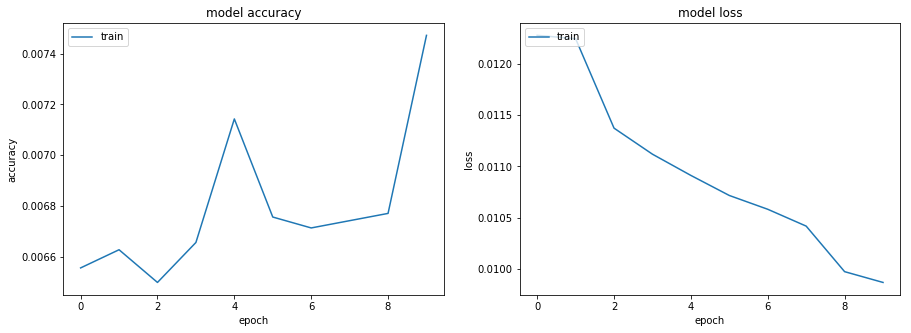

In [299]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Loss"
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Let's have the network predict some sounds based on the original training data to see if it has learned something. We can compare the original audio to the network predictions and reference training material.

In [300]:
audio_prediction = processor.predict(train_x[:4000], batch_size=50, verbose=True)

4000/4000 [==============================] - 63s    


In [301]:
audio_prediction = (audio_prediction.flatten() / 2) - 1
ref = (train_y.flatten() / 2) - 1

In [302]:
import IPython
# print("Original: ")
# IPython.display.Audio(audio[8000000:9000000], rate=88200)
print("Predicted: ")
IPython.display.Audio(audio_prediction[:2000000], rate=88200)
# print("Reference: ")
# IPython.display.Audio(val_audio[8000000:9000000], rate=88200)

Predicted: 


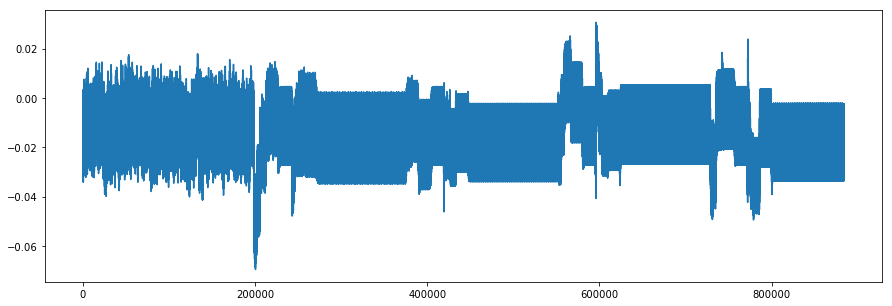

In [303]:
plt.figure(figsize=(15,5))
plt.plot(audio_prediction)
plt.show()